In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df_users=pd.read_csv("takehome_users.csv")
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
df_engage=pd.read_csv("takehome_user_engagement.csv")
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Classifying users as adopted or non-adopted

In [4]:
# convert to date-time format
df_engage['date_time']=pd.to_datetime(df_engage.time_stamp)
df_engage.reset_index(inplace=True)
df_engage.set_index(pd.DatetimeIndex(df_engage['date_time']), inplace=True)

In [5]:
# get counts per day
per_day=df_engage.groupby([pd.TimeGrouper('D'), 'user_id'])['visited'].sum()
per_day=per_day.reset_index()
per_day.sort_values(['user_id', 'date_time'], ascending=[True, False], inplace=True)
per_day.set_index(pd.DatetimeIndex(per_day['date_time']), inplace=True)

In [6]:
#fill in the missing dates and add zeros to the visited column
def fill_dates(group):
    idx = pd.date_range(group.date_time.min(), group.date_time.max())
    return group.reindex(idx, fill_value=0)
per_day_alldates=per_day.groupby('user_id').apply(fill_dates)
per_day_alldates.head()

date_time  user_id  visited
user_id                                        
1       2014-04-22 2014-04-22        1        1
2       2013-11-15 2013-11-15        2        1
        2013-11-16 1970-01-01        0        0
        2013-11-17 1970-01-01        0        0
        2013-11-18 1970-01-01        0        0

In [7]:
#remove user_id column as filled with zeros when reindexing 
per_day_alldates_visits=per_day_alldates[['visited']] 
#reset index to make user_id a column, keep only dates indexed
per_day_alldates_visits.reset_index(level='user_id',inplace=True) 
#calculate a rollingsum from first to last login date, to get logins in a 7-day window 
seven_day_sum=per_day_alldates_visits.groupby('user_id')['visited'].rolling(7).sum()
seven_day_sum=seven_day_sum.reset_index(level='user_id') 

In [8]:
#fill NAs with zeros
seven_day_sum.fillna(0, inplace=True)
#get max logins in a seven day window for each user
user_max_logins=seven_day_sum.groupby('user_id')['visited'].max()
user_max_logins=user_max_logins.reset_index(level='user_id') 
#If user has logged in >3 times in 7 day window- mark as adopted 
user_max_logins['adopted']=True
user_max_logins['adopted'][user_max_logins['visited']<3]=False
user_max_logins.head()

/Users/taniajogesh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,user_id,visited,adopted
0,1,0.0,False
1,2,3.0,True
2,3,0.0,False
3,4,0.0,False
4,5,0.0,False


In [9]:
full_df=df_users.merge(user_max_logins, left_on='object_id', right_on='user_id', how='inner')
full_df['creation_time']=pd.to_datetime(full_df.creation_time)
full_df['month']=full_df['creation_time'].dt.month
full_df['year']=full_df['creation_time'].dt.year
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 15 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
user_id                       8823 non-null int64
visited                       8823 non-null float64
adopted                       8823 non-null bool
month                         8823 non-null int64
year                          8823 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(7), object(3)
memory usage: 1.0+ MB


## EDA

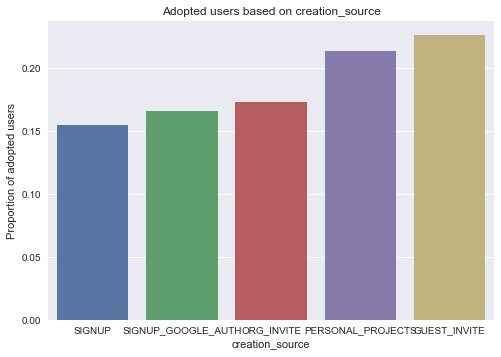

In [10]:
creation_source=pd.crosstab(index=full_df["creation_source"],  # Make a crosstab
                              columns=full_df["adopted"]).apply(lambda r: r/r.sum(), axis=1)
creation_source.reset_index(inplace=True)
creation_source.columns=['creation_source','False','True']
creation_source.sort_values('True',inplace=True)
ax = sns.barplot(x="creation_source", y="True", data=creation_source)
plt.xlabel("creation_source")
plt.ylabel("Proportion of adopted users")
plt.title("Adopted users based on creation_source") 
plt.show()


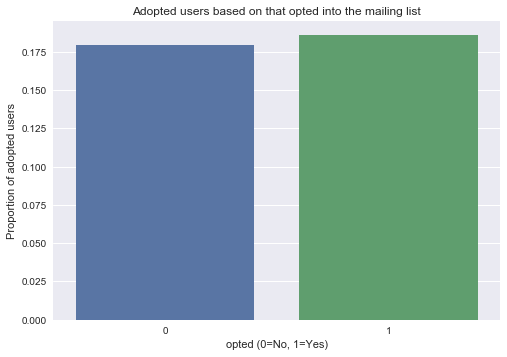

In [11]:
opted_in_to_mailing_list=pd.crosstab(index=full_df["opted_in_to_mailing_list"],  # Make a crosstab
                              columns=full_df["adopted"]).apply(lambda r: r/r.sum(), axis=1)
opted_in_to_mailing_list.reset_index(inplace=True)
opted_in_to_mailing_list.columns=['opted_in_to_mailing_list','False','True']
opted_in_to_mailing_list.sort_values('True',inplace=True)
ax = sns.barplot(x="opted_in_to_mailing_list", y="True", data=opted_in_to_mailing_list)
plt.xlabel("opted (0=No, 1=Yes)")
plt.ylabel("Proportion of adopted users")
plt.title("Adopted users based on that opted into the mailing list") 
plt.show()


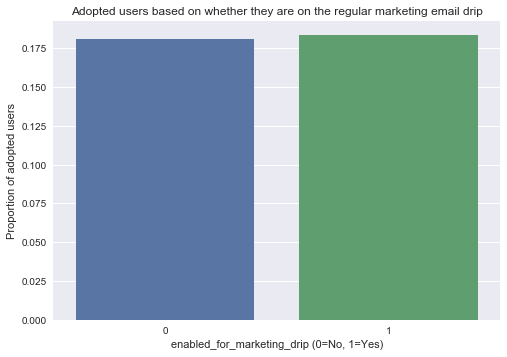

In [12]:
enabled_for_marketing_drip=pd.crosstab(index=full_df["enabled_for_marketing_drip"],  # Make a crosstab
                              columns=full_df["adopted"]).apply(lambda r: r/r.sum(), axis=1)
enabled_for_marketing_drip.reset_index(inplace=True)
enabled_for_marketing_drip.columns=['enabled_for_marketing_drip','False','True']
enabled_for_marketing_drip.sort_values('True',inplace=True)
ax = sns.barplot(x="enabled_for_marketing_drip", y="True", data=enabled_for_marketing_drip)
plt.xlabel("enabled_for_marketing_drip (0=No, 1=Yes)")
plt.ylabel("Proportion of adopted users")
plt.title("Adopted users based on whether they are on the regular marketing email drip") 
plt.show()


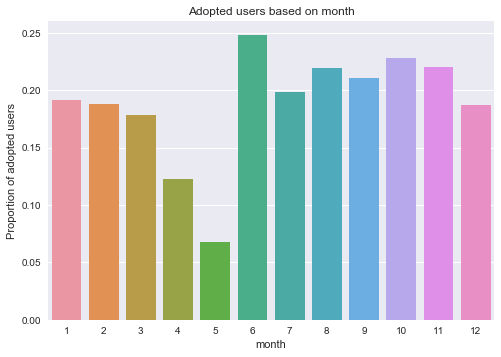

In [13]:
month=pd.crosstab(index=full_df["month"],  # Make a crosstab
                              columns=full_df["adopted"]).apply(lambda r: r/r.sum(), axis=1)
month.reset_index(inplace=True)
month.columns=['month','False','True']
month.sort_values('True',inplace=True)
ax = sns.barplot(x="month", y="True", data=month)
plt.xlabel("month")
plt.ylabel("Proportion of adopted users")
plt.title("Adopted users based on month") 
plt.show()


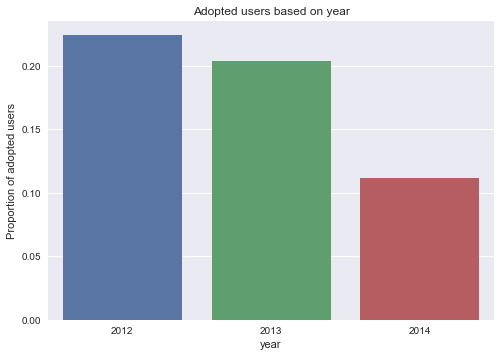

In [14]:
year=pd.crosstab(index=full_df["year"],  # Make a crosstab
                              columns=full_df["adopted"]).apply(lambda r: r/r.sum(), axis=1)
year.reset_index(inplace=True)
year.columns=['year','False','True']
year.sort_values('True',inplace=True)
ax = sns.barplot(x="year", y="True", data=year)
plt.xlabel("year")
plt.ylabel("Proportion of adopted users")
plt.title("Adopted users based on year") 
plt.show()


## ML Classifier 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [16]:
encoder = OneHotEncoder()
label_encoder = LabelEncoder()

features = full_df[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','month','year']]
target = full_df['adopted']

features.month = label_encoder.fit_transform(features['month'])
features.year = label_encoder.fit_transform(features['year'])
features.org_id = label_encoder.fit_transform(features['org_id'])
features.creation_source = label_encoder.fit_transform(features['creation_source'])

month = encoder.fit_transform(features[['month']]).toarray()
year = encoder.fit_transform(features[['year']]).toarray()
org = encoder.fit_transform(features[['org_id']]).toarray()
source = encoder.fit_transform(features[['creation_source']]).toarray()

numeric_cols = ['opted_in_to_mailing_list','enabled_for_marketing_drip']
numeric_features = features[numeric_cols].values

Y = label_encoder.fit_transform(target)
X=np.concatenate([month,year,org,source,numeric_features], axis=1)

/Users/taniajogesh/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.30)
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(xtrain, ytrain)
training_accuracy = forest.score(xtrain, ytrain)
test_accuracy = forest.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.985589
Accuracy on test data:     0.807707


ROC AUC: 0.58


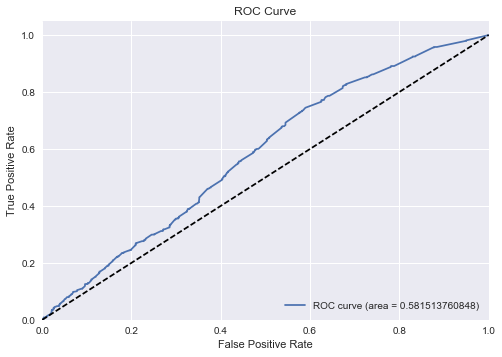

In [18]:
# Calculate the AUC
fpr, tpr, thresholds = roc_curve(ytest, forest.predict_proba(xtest)[:,1])
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

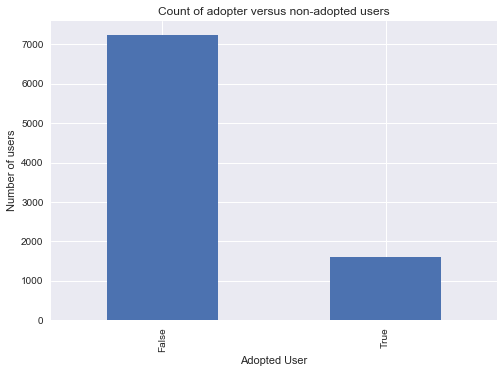

In [19]:
## The AUC suggests that the data are unbalanced. so the accuracy is high by increased predictions of non-adopted users
## but the model is pretty poor in terms of its predictions. 
full_df.groupby('adopted')['object_id'].count().plot.bar()
plt.xlabel("Adopted User")
plt.ylabel("Number of users")
plt.title("Count of adopter versus non-adopted users") 
plt.show()

### create balanced design by subsampling

In [20]:
## create balanced design bu subsampling
full_df_not_adopted = full_df[full_df.adopted==False]
full_df_not_adopted_sample= full_df_not_adopted.sample(frac=0.20)
full_df_adopted = full_df[full_df.adopted==True]
partial_df=pd.concat([full_df_not_adopted_sample, full_df_adopted])

In [21]:
encoder = OneHotEncoder()
label_encoder = LabelEncoder()

features = partial_df[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','month','year']]
target = partial_df['adopted']

features.month = label_encoder.fit_transform(features['month'])
features.year = label_encoder.fit_transform(features['year'])
features.org_id = label_encoder.fit_transform(features['org_id'])
features.creation_source = label_encoder.fit_transform(features['creation_source'])

month = encoder.fit_transform(features[['month']]).toarray()
year = encoder.fit_transform(features[['year']]).toarray()
org = encoder.fit_transform(features[['org_id']]).toarray()
source = encoder.fit_transform(features[['creation_source']]).toarray()

numeric_cols = ['opted_in_to_mailing_list','enabled_for_marketing_drip']
numeric_features = features[numeric_cols].values

Y = label_encoder.fit_transform(target)
X=np.concatenate([month,year,org,source,numeric_features], axis=1)

In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.30)
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit(xtrain, ytrain)
training_accuracy = forest.score(xtrain, ytrain)
test_accuracy = forest.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.990606
Accuracy on test data:     0.534502


In [23]:
### When we balance the design, can see that the model accuracy is pretty poor and the model is overfitting the data

In [24]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.50)
svc_clf = SVC(kernel='linear', C=1, gamma=1) 
svc_model = svc_clf.fit(xtrain, ytrain)
training_accuracy = svc_model.score(xtrain, ytrain)
test_accuracy = svc_model.score(xtest, ytest)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.714661
Accuracy on test data:     0.510848


In [25]:
## accuracy doesn't improve with models. I think the data would improve substantially with additional features